<a href="https://colab.research.google.com/github/vaani787/Lane.detection/blob/main/way_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
files = ["/content/drive/MyDrive/kitti_dataset/" + i for i in os.listdir("/content/drive/MyDrive/kitti_dataset/")]
files.pop();

In [ ]:
files

['/content/drive/MyDrive/kitti_dataset/0000000017.png',
 '/content/drive/MyDrive/kitti_dataset/0000000083.png',
 '/content/drive/MyDrive/kitti_dataset/0000000110.png',
 '/content/drive/MyDrive/kitti_dataset/0000000177.png',
 '/content/drive/MyDrive/kitti_dataset/0000000031.png',
 '/content/drive/MyDrive/kitti_dataset/0000000006.png']

#**Function to Draw Images**


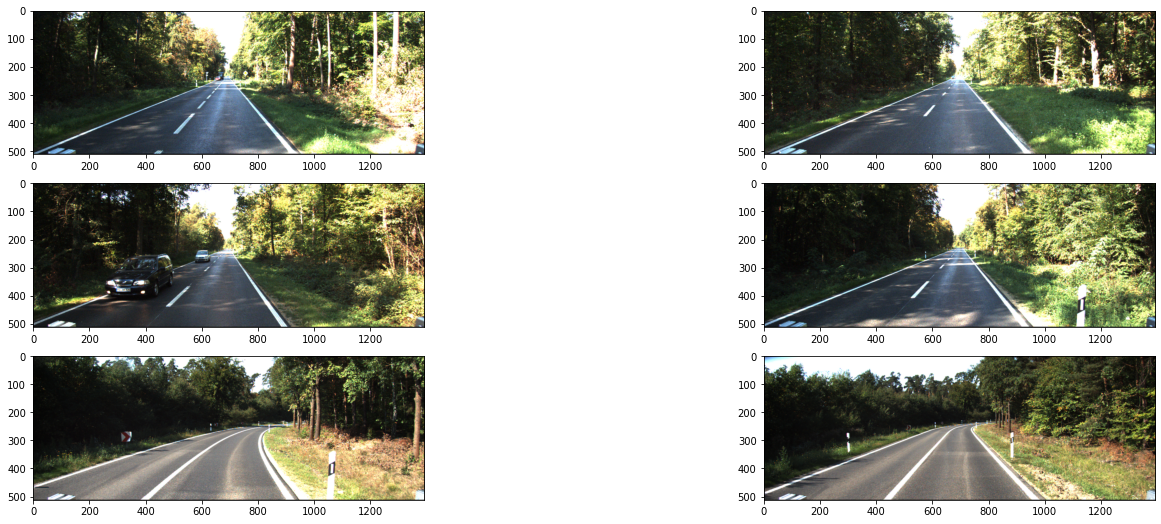

In [ ]:
def draw_imgs(lst, rows = 3, cols=2, figsize=(24, 9)):
    fig = plt.figure(figsize=figsize)
    fig.tight_layout()
    for i in range(1, rows * cols +1):
        fig.add_subplot(rows, cols, i)
        img = mpimg.imread(lst[i-1])
        plt.imshow(img)

draw_imgs(files)

**Workflow 1**


1. Undistortion
2. Gray scaling
3. Gaussian
4. Binary Thresholding
5. Canny
6. Hough


#**Plot original and modified image**

In [238]:
def plot_images(original, modified, title1, title2):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(cv2.cvtColor(modified, cv2.COLOR_BGR2RGB), cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#**Undistortion**

In [239]:
def undistort(img_name):
    img = cv2.imread(img_name)
    mtx = np.array([[9.597910e+02,0.000000e+00,6.960217e+02],[0.000000e+00,9.569251e+02,2.241806e+02],[0.000000e+00,0.000000e+00,1.000000e+00]])
    dist = np.array([[-3.691481e-01,1.968681e-01,1.353473e-03,5.677587e-04,-6.770705e-02]])
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    return undist

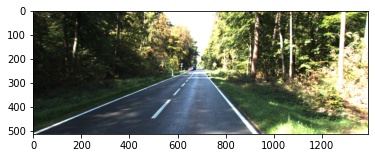

In [240]:
undistorted_img=undistort(files[0])# Undistored
plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

#**Bounding box**

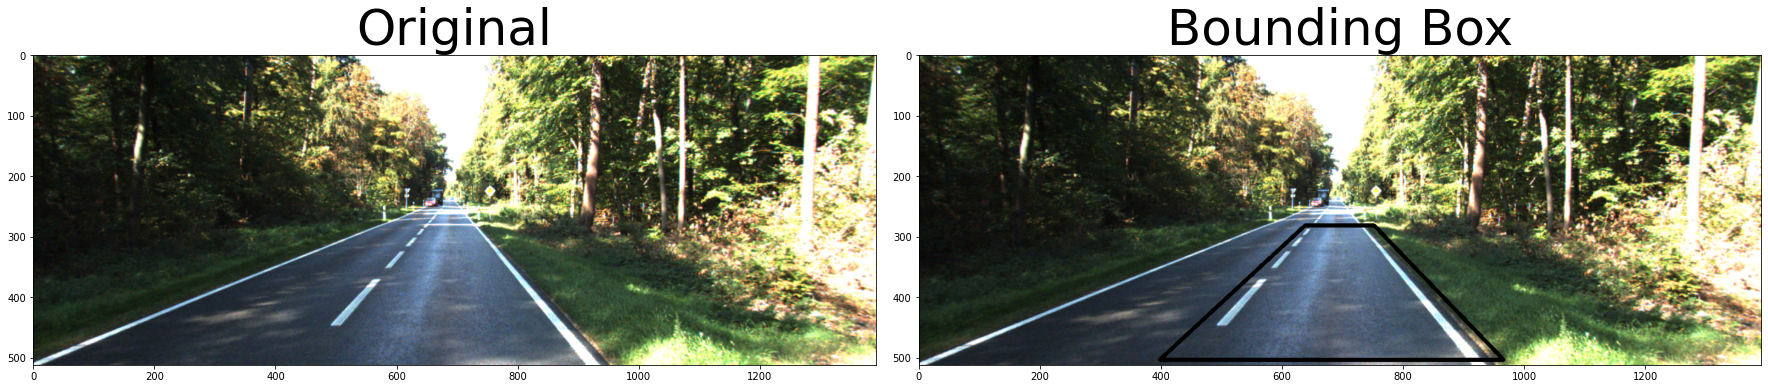

In [241]:
img = undistorted_img.copy()
b_l=(397,503)
b_r=(965,503)
t_r=(751,281)
t_l=(637,281)
points = [b_l,b_r,t_r,t_l]
cv2.line(img, points[0], points[1], 0, 5)
cv2.line(img, points[1], points[2], 0, 5)
cv2.line(img, points[2], points[3], 0, 5)
cv2.line(img, points[3], points[0], 0, 5)

plot_images(undistorted_img, img, "Original", "Bounding Box")

#**Preprocessing**

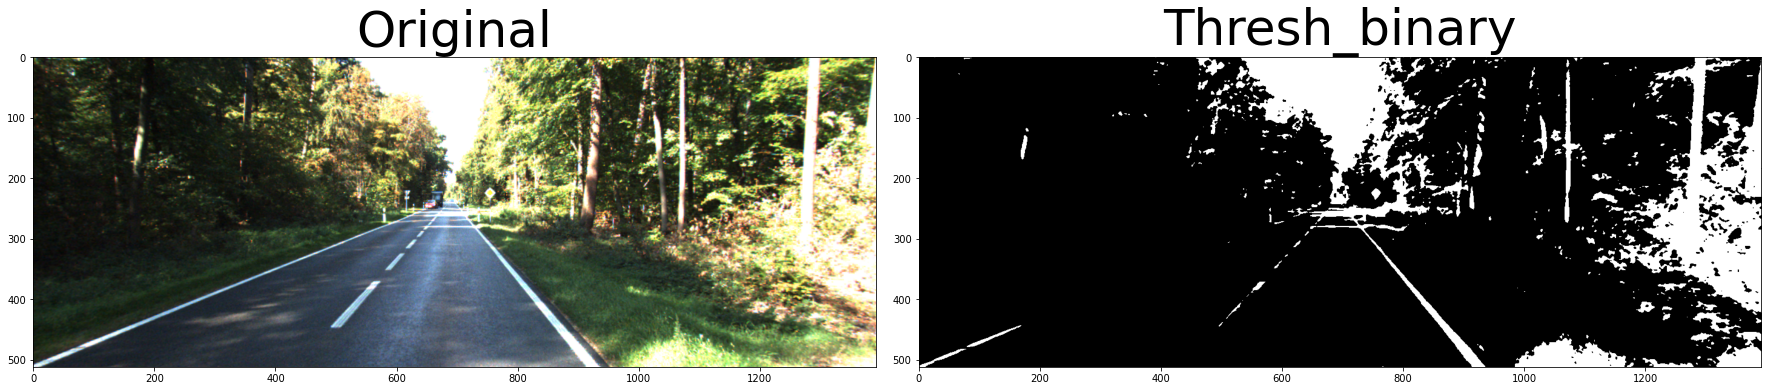

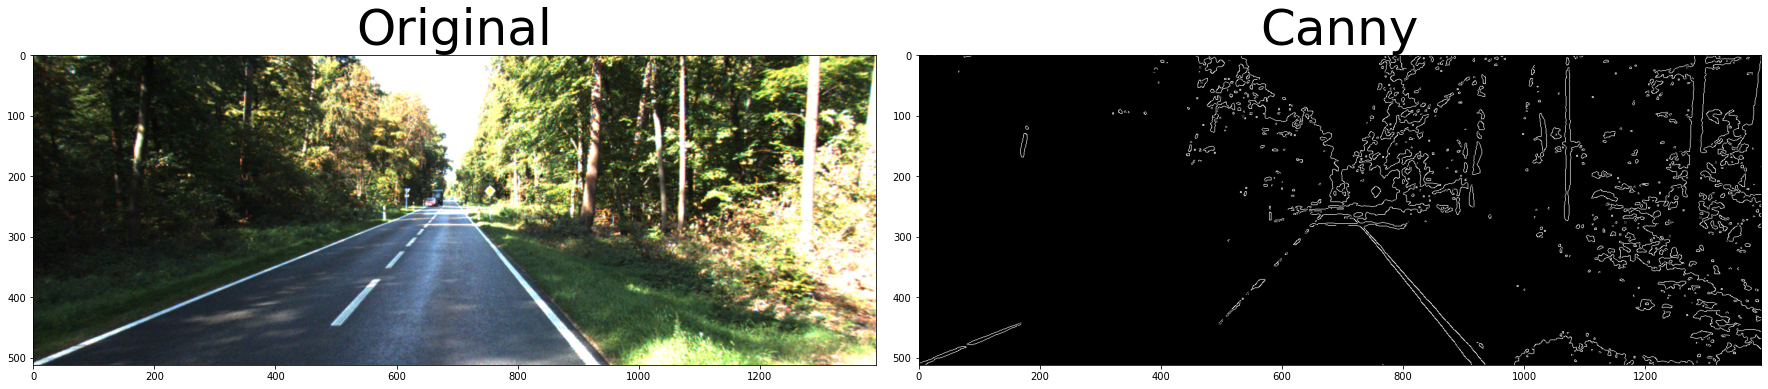

In [242]:
grayImage = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(grayImage,(5,5),0)
(thresh, blackAndWhiteImage) = cv2.threshold(blur,200, 255, cv2.THRESH_BINARY)
canny = cv2.Canny(blackAndWhiteImage,50,150)

plot_images(undistorted_img,blackAndWhiteImage, 'Original','Thresh_binary')
plot_images(undistorted_img,canny,'Original','Canny')

#**Bounding box masking**

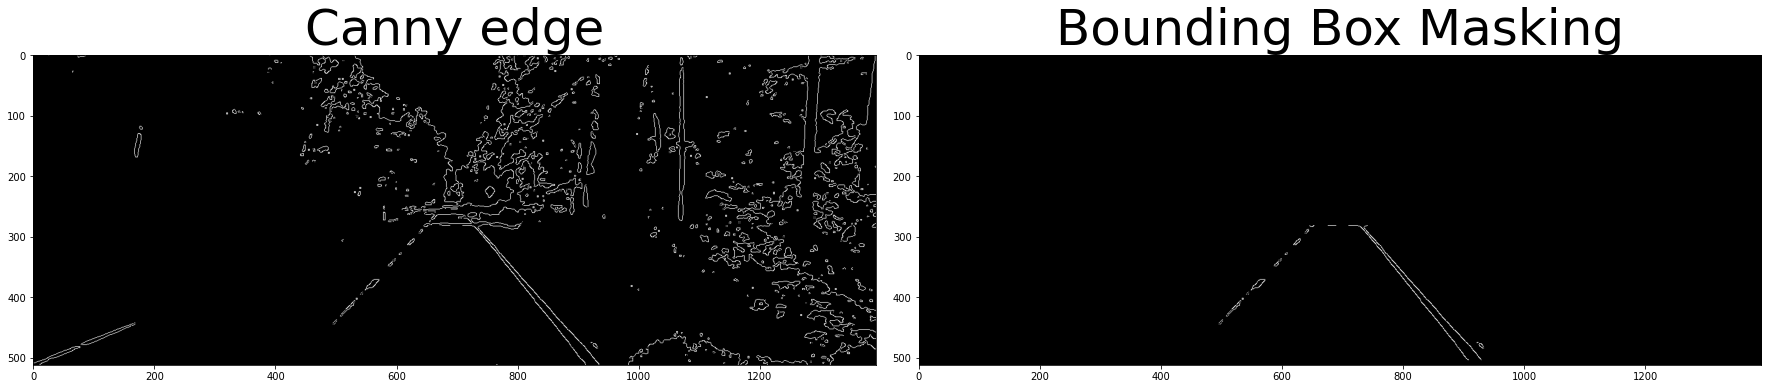

In [243]:
points = np.array([points])
mask = np.zeros_like(canny)
cv2.fillPoly(mask, points,255)
segment = cv2.bitwise_and(canny, mask)

plot_images(canny, segment,'Canny edge', "Bounding Box Masking")

#**Hough transform**

In [331]:
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        cv2.line(line_image,(x1,y1),(x2,y2),(31,0,255),6)
    return line_image

[[[509 427 648 283]]

 [[740 295 827 402]]

 [[529 413 652 281]]

 [[744 297 927 501]]

 [[729 283 907 503]]]


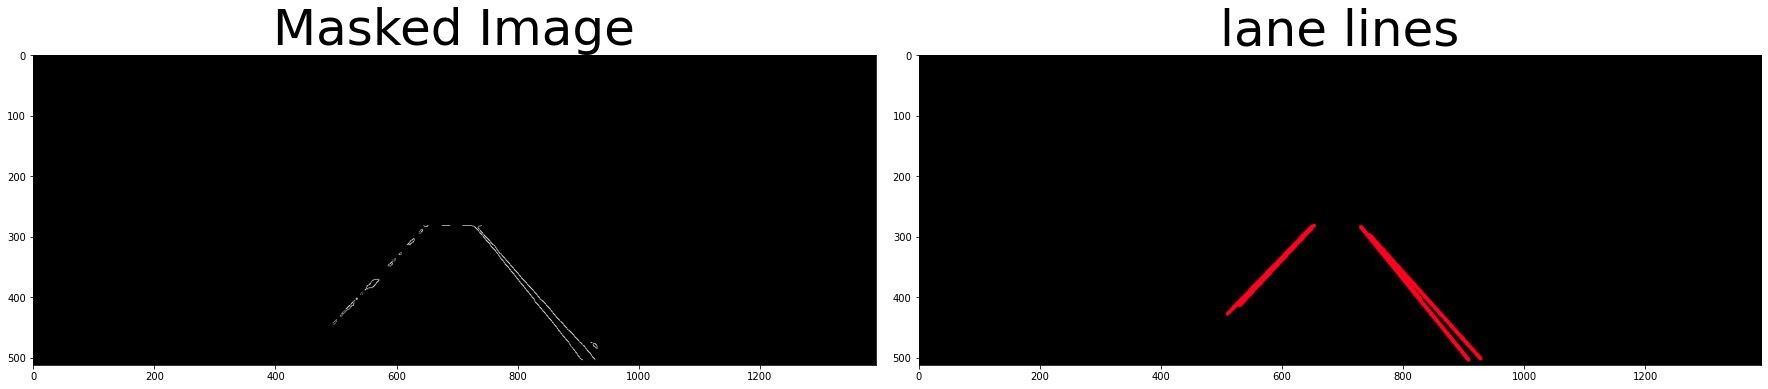

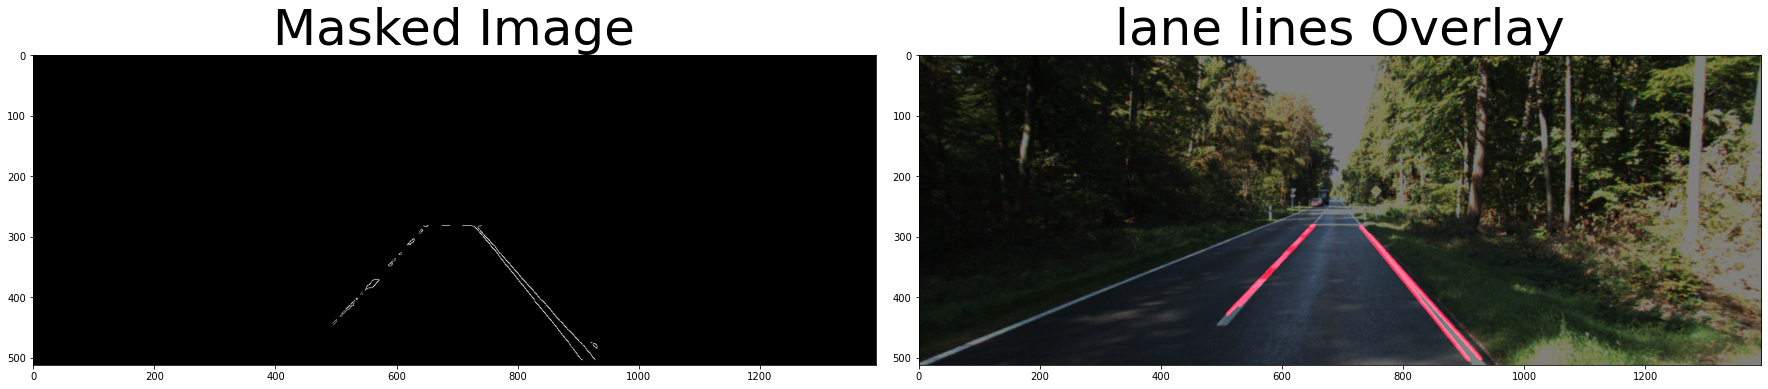

In [332]:
lines = cv2.HoughLinesP(segment, 2, np.pi / 180, 0, np.array([]), minLineLength = 100, maxLineGap = 30)
print(lines)
line_image = display_lines(undistorted_img,lines)
overlay_img = cv2.addWeighted(undistorted_img,0.5,line_image,1,1)

plot_images(segment,line_image,'Masked Image','lane lines')
plot_images(segment,overlay_img,'Masked Image','lane lines Overlay')

#**Separating left and right lanes**

In [333]:
bottom_mid=(b_l[0]+b_r[0])/2
top_mid=(t_l[0]+t_r[0])/2
mid_pt=(top_mid+bottom_mid)/2
print(mid_pt)

687.5


In [334]:
right_lane=[]
left_lane=[]
for i in lines:
    
    if (i[0][0]>687.5 and i[0][2]>687.5 ):
        right_lane.append(i[0])
    else:
        left_lane.append(i[0])   
right_lane=np.array(right_lane)
left_lane=np.array(left_lane)
print(right_lane,"\n\n")
print(left_lane)

right_line_image = display_lines(undistorted_img,right_lane)
left_line_image = display_lines(undistorted_img,left_lane)


[[740 295 827 402]
 [744 297 927 501]
 [729 283 907 503]] 


[[509 427 648 283]
 [529 413 652 281]]


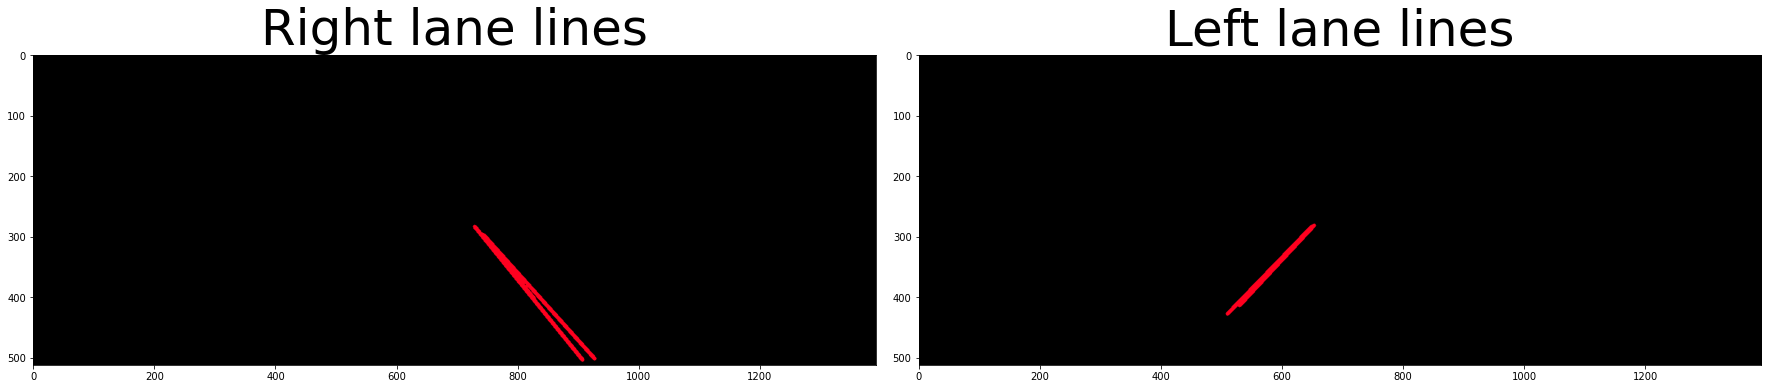

In [335]:
plot_images(right_line_image,left_line_image,'Right lane lines','Left lane lines')

#**Finding best fitting lane lines**

Right lane

In [336]:
x_right=[]
y_right=[]
for i in right_lane:
    x_right.append(i[0])
    x_right.append(i[2])
    
    y_right.append(i[1])
    y_right.append(i[3])

print("x_right  ",x_right)
print("y_right  ",y_right)

x_right   [740, 827, 744, 927, 729, 907]
y_right   [295, 402, 297, 501, 283, 503]


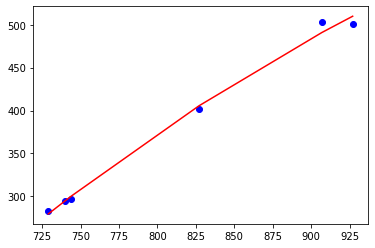

In [337]:
plt.scatter(x_right,y_right,color='b',label='Data points')
x_right=np.array(x_right)
x_sorted_right=np.sort(x_right)
y_right=np.array(y_right)
fit1 = np.polyfit(x_right, y_right, 2)
a1 = fit1[0]
b1 = fit1[1]
c1 = fit1[2]
fit_equation_right = a1 * np.square(x_sorted_right) + b1 * x_sorted_right + c1

plt.plot(x_sorted_right,fit_equation_right,color='r')

[[927 509 729 279]]


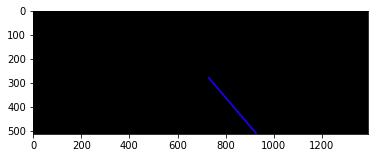

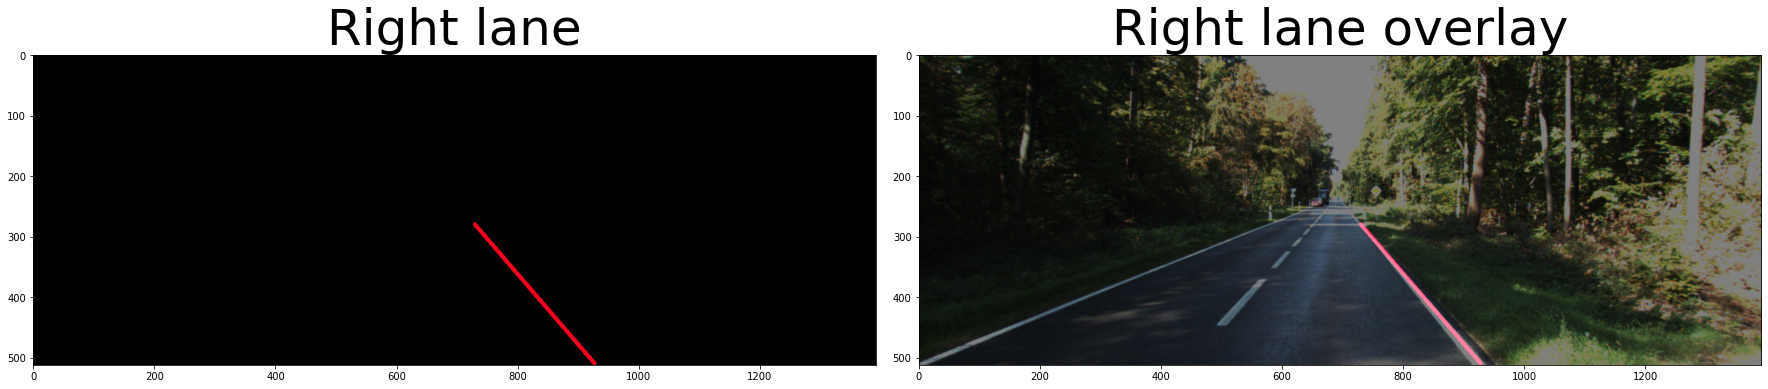

In [346]:
b_l=(397,503)
b_r=(965,503)
t_r=(751,281)
t_l=(637,281)
right_lane_single=[]
right_lane_single.extend([x_sorted_right[-1],int(a1*np.square(x_sorted_right[-1])+b1*x_sorted_right[-1]+c1)])
right_lane_single.append(x_sorted_right[0])
right_lane_single.append(int(a1*np.square(x_sorted_right[0])+b1*x_sorted_right[0]+c1))
right_lane_single=np.array([right_lane_single])
print(right_lane_single)

final_right_lane=display_lines(undistorted_img,right_lane_single)
plt.imshow(final_right_lane)

overlay_right = cv2.addWeighted(undistorted_img,0.5,final_right_lane,1,1)
plot_images(final_right_lane,overlay_right,'Right lane','Right lane overlay')

Left lane

In [339]:
x_left=[]
y_left=[]
for i in left_lane:
    x_left.append(i[0])
    x_left.append(i[2])
    
    y_left.append(i[1])
    y_left.append(i[3])
print("x_left  ",x_left)
print("y_left  ",y_left)

x_left   [509, 648, 529, 652]
y_left   [427, 283, 413, 281]


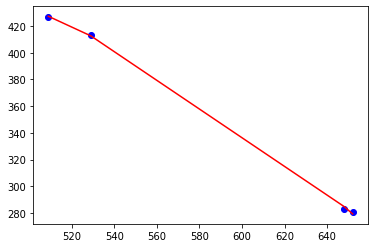

In [340]:
plt.scatter(x_left,y_left,color='b',label='Data points')
x_left=np.array(x_left)
x_sorted_left=np.sort(x_left)
y_left=np.array(y_left)
fit2 = np.polyfit(x_left, y_left, 2)
a2 = fit2[0]
b2 = fit2[1]
c2 = fit2[2]
fit_equation_left = a2 * np.square(x_sorted_left) + b2 * x_sorted_left + c2

plt.plot(x_sorted_left,fit_equation_left,color='r')

[[509 427 652 279]]


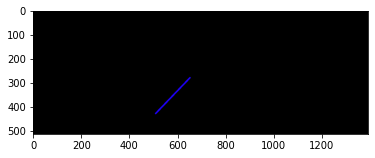

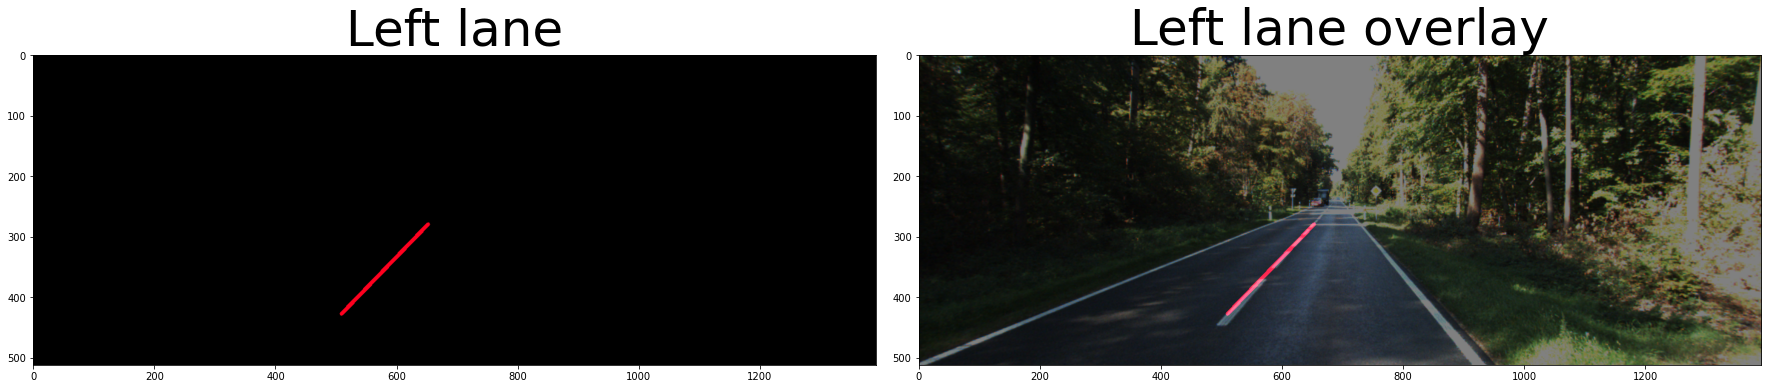

In [347]:
b_l=(397,503)
b_r=(965,503)
t_r=(751,281)
t_l=(637,281)
left_lane_single=[]
left_lane_single.extend([x_sorted_left[0],int(a2*np.square(x_sorted_left[0])+b2*x_sorted_left[0]+c2)])
left_lane_single.append(x_sorted_left[-1])
left_lane_single.append(int(a2*np.square(x_sorted_left[-1])+b2*x_sorted_left[-1]+c2))
left_lane_single=np.array([left_lane_single])
print(left_lane_single)

final_left_lane=display_lines(undistorted_img,left_lane_single)
plt.imshow(final_left_lane)

overlay_left = cv2.addWeighted(undistorted_img,0.5,final_left_lane,1,1)
plot_images(final_left_lane,overlay_left,'Left lane','Left lane overlay')

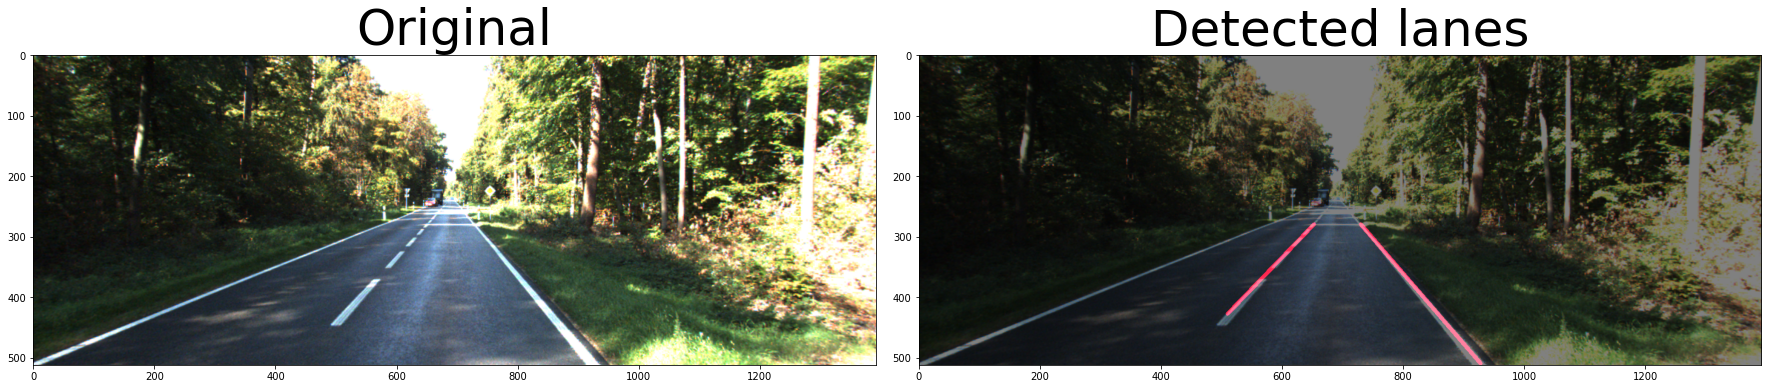

In [348]:
overlay_final = cv2.addWeighted(undistorted_img,0.5,final_right_lane+final_left_lane,1,1)
plot_images(undistorted_img,overlay_final,'Original','Detected lanes')